# Data Load


In [63]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from google.colab import drive
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [64]:
lxyz = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959322/DEBY_LOD2_4959322.xyz', sep=" ", header=0)
lxyz.columns = ["x", "y", "z", "cla"]
print(lxyz.cla.value_counts())

lxyz_test = pd.read_csv('./data/test/labelledLocalCRS/DEBY_LOD2_4959459/DEBY_LOD2_4959459.xyz', sep=" ", header=0)
lxyz_test.columns = ["x", "y", "z", "cla"]
print(lxyz_test.cla.value_counts())

############## !! Here you can choose whether to use large dataset ###############

1     2869200
2      826645
5      746775
12     378061
16     366536
17     209118
3      111354
15      35457
11      22421
9        7342
13       1932
6        1319
14        731
Name: cla, dtype: int64
1     417280
2     276623
16    177257
5      93060
13     41630
17     24679
12     14055
3       4101
4       1072
9        682
Name: cla, dtype: int64


In [2]:
# lxyz = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959322/DEBY_LOD2_4959322.xyz', sep=" ", header=0)
# lxyz.columns = ["x", "y", "z", "cla"]
lxyz_1 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4906981/DEBY_LOD2_4906981.xyz', sep=" ", header=0)
lxyz_1.columns = ["x", "y", "z", "cla"]
lxyz_2 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959322/DEBY_LOD2_4959322.xyz', sep=" ", header=0)
lxyz_2.columns = ["x", "y", "z", "cla"]
lxyz_3 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959460/DEBY_LOD2_4959460.xyz', sep=" ", header=0)
lxyz_3.columns = ["x", "y", "z", "cla"]
lxyz_4 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959462/DEBY_LOD2_4959462.xyz', sep=" ", header=0)
lxyz_4.columns = ["x", "y", "z", "cla"]
lxyz = pd.concat([lxyz_1, lxyz_2, lxyz_3, lxyz_4], axis = 0)
print(lxyz.cla.value_counts())

lxyz_test = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959323/DEBY_LOD2_4959323.xyz', sep=" ", header=0)
lxyz_test.columns = ["x", "y", "z", "cla"]
print(lxyz_test.cla.value_counts())

1     36429131
16     7566216
11     7534665
5      7056168
2      6351914
12     5938935
15     3797046
17     3600867
7      1393392
3       691885
6       475590
10      419409
14      304608
8       220774
13       49393
9        29398
Name: cla, dtype: int64
1     19125652
5      6440977
2      3448050
12     1979855
16     1911652
17     1746219
6       628964
3       288073
14      242680
13       24642
Name: cla, dtype: int64


# Sample Points & Merge class

In [65]:
lclass = lxyz['cla'].replace({6:5,9:1,15:1,10:1,12:11,17:13,16:13,14:2,4:1})
print(lclass.value_counts())

lclass_test = lxyz_test['cla'].replace({6:5,9:1,15:1,10:1,12:11,17:13,16:13,14:2,4:1})
print(lclass_test.value_counts())

1     2911999
2      827376
5      748094
13     577586
11     400482
3      111354
Name: cla, dtype: int64
1     419034
2     276623
13    243566
5      93060
11     14055
3       4101
Name: cla, dtype: int64


In [66]:
lclass = lclass.replace({5:4,13:5,11:6})
print(lclass.value_counts())
# 1: wall
# 2: window
# 3: door
# 4: molding
# 5: other
# 6: terrian
# 7: column
# 8: arch

lclass_test = lclass_test.replace({5:4,13:5,11:6})
print(lclass_test.value_counts())

1    2911999
2     827376
4     748094
5     577586
6     400482
3     111354
Name: cla, dtype: int64
1    419034
2    276623
5    243566
4     93060
6     14055
3      4101
Name: cla, dtype: int64


In [67]:
lclass = lclass.replace({1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7})
print(lclass.value_counts())
# 0: wall
# 1: window
# 2: door
# 3: molding
# 4: other
# 5: terrian
# 6: column
# 7: arch

lclass_test = lclass_test.replace({1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7})
print(lclass_test.value_counts())

0    2911999
1     827376
3     748094
4     577586
5     400482
2     111354
Name: cla, dtype: int64
0    419034
1    276623
4    243566
3     93060
5     14055
2      4101
Name: cla, dtype: int64


In [68]:
lxyz = lxyz.drop('cla',axis = 1) 
lxyz_test = lxyz_test.drop('cla',axis = 1) 

lxyz = lxyz.to_numpy().reshape(-1,3)
lxyz_test = lxyz_test.to_numpy().reshape(-1,3)

In [69]:
import open3d as o3d

In [70]:
######################### using open3d for point processing ################
device = o3d.core.Device("CPU:0")
dtype = o3d.core.float32
pcd = o3d.t.geometry.PointCloud(device)
pcd.point.positions = o3d.core.Tensor(lxyz, dtype, device)
pcd.point.labels = o3d.core.Tensor(lclass.to_numpy().reshape(-1,1), o3d.core.int32, device)
# o3d.visualization.draw([pcd])
downpcd = pcd.voxel_down_sample(voxel_size = 0.05)

In [71]:
lxyz_train = downpcd.point.positions.numpy()
lclass_train = downpcd.point.labels.numpy()

pcd_train = o3d.geometry.PointCloud()
pcd_train.points = o3d.utility.Vector3dVector(lxyz_train)

# color
colors = plt.get_cmap("tab20")(np.array(lclass_train).reshape(-1) / 17.0)
colors = colors[:,0:3]
pcd_train.colors=o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd_train], window_name='test the color',width=800,height=600)

In [72]:
print(len(lxyz_train)) # see how many points after simplified

1241136


In [73]:
pcd_test = o3d.t.geometry.PointCloud(device)
pcd_test.point.positions = o3d.core.Tensor(lxyz_test, dtype, device)
pcd_test.point.labels = o3d.core.Tensor(lclass_test.to_numpy().reshape(-1,1), o3d.core.int32, device)
# o3d.visualization.draw([pcd])
downpcd_test = pcd_test.voxel_down_sample(voxel_size = 0.05)

lxyz_test = downpcd_test.point.positions.numpy()
lclass_test = downpcd_test.point.labels.numpy()

In [74]:
pcd_test = o3d.geometry.PointCloud()
pcd_test.points = o3d.utility.Vector3dVector(lxyz_test)

# color
colors = plt.get_cmap("tab20")(np.array(lclass_test).reshape(-1) / 17.0)
colors = colors[:,0:3]
pcd_test.colors=o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd_test], window_name='test the color',width=800,height=600)

# Add Features （ IF NOT KEEP AS X Y Z）

In [75]:
lxyz_train = pd.DataFrame(lxyz_train)
lxyz_train.columns = ["x", "y", "z"]

In [76]:
lxyz_test = pd.DataFrame(lxyz_test)
lxyz_test.columns = ["x", "y", "z"]

In [77]:
########## Normalization For Each Column ##########
def normalize_point_cloud(pcd):
    centroid = np.mean(pcd, axis=0) # calculation the center of point cloud
    pcd = pcd - centroid # put the center as origin
    m = np.max(np.sqrt(np.sum(pcd ** 2, axis=1))) # calculation the longest vector
    pcd_normalized = pcd / m # normalization to (-1, 1)
    return pcd_normalized


In [78]:
norm_lxyz_train = normalize_point_cloud(lxyz_train)
norm_lxyz_test = normalize_point_cloud(lxyz_test)

In [79]:
lclass_train = pd.DataFrame(lclass_train, columns = ['cla'], dtype = int)
lclass_test = pd.DataFrame(lclass_test, columns = ['cla'], dtype = int)

In [80]:
print(lclass_test.value_counts())

cla
0      232389
4      173752
1      149798
3       56679
5       12296
2        2676
dtype: int64


In [81]:
print(lclass_train)

         cla
0          0
1          0
2          0
3          0
4          0
...      ...
1241131    4
1241132    4
1241133    4
1241134    4
1241135    4

[1241136 rows x 1 columns]


In [82]:
print(lclass_test)

        cla
0         4
1         4
2         4
3         4
4         4
...     ...
627585    4
627586    4
627587    4
627588    4
627589    4

[627590 rows x 1 columns]


In [83]:
print(norm_lxyz_train)

                x         y         z
0        0.055158  0.046167  0.145007
1        0.055158  0.048114  0.098288
2        0.055158  0.059794 -0.195654
3        0.055158  0.061740 -0.219013
4        0.055158  0.053954 -0.170347
...           ...       ...       ...
1241131 -0.055800  0.098726 -0.000990
1241132 -0.055800  0.100673  0.012636
1241133 -0.055800  0.096780 -0.000990
1241134 -0.472380  0.273923 -0.006830
1241135 -0.480166  0.268084 -0.076909

[1241136 rows x 3 columns]


In [84]:
print(norm_lxyz_test)

               x         y         z
0       0.476475  0.267497 -0.053678
1       0.475024  0.264596  0.294546
2       0.475024  0.263145  0.294546
3       0.475024  0.267497  0.295997
4       0.475024  0.258792  0.307604
...          ...       ...       ...
627585 -0.337498 -0.459420 -0.214731
627586 -0.337498 -0.460871 -0.214731
627587 -0.337498 -0.455067 -0.216182
627588 -0.338949 -0.457969 -0.214731
627589 -0.338949 -0.449263 -0.214731

[627590 rows x 3 columns]


# Data Spilt

In [85]:
lxyz_train = pd.concat([norm_lxyz_train, lclass_train], axis = 1)
lxyz_test = pd.concat([norm_lxyz_test, lclass_test], axis = 1)
# print(lxyz_test.cla.value_counts())

In [86]:
print(lxyz_train)
print(lxyz_test)

                x         y         z  cla
0        0.055158  0.046167  0.145007    0
1        0.055158  0.048114  0.098288    0
2        0.055158  0.059794 -0.195654    0
3        0.055158  0.061740 -0.219013    0
4        0.055158  0.053954 -0.170347    0
...           ...       ...       ...  ...
1241131 -0.055800  0.098726 -0.000990    4
1241132 -0.055800  0.100673  0.012636    4
1241133 -0.055800  0.096780 -0.000990    4
1241134 -0.472380  0.273923 -0.006830    4
1241135 -0.480166  0.268084 -0.076909    4

[1241136 rows x 4 columns]
               x         y         z  cla
0       0.476475  0.267497 -0.053678    4
1       0.475024  0.264596  0.294546    4
2       0.475024  0.263145  0.294546    4
3       0.475024  0.267497  0.295997    4
4       0.475024  0.258792  0.307604    4
...          ...       ...       ...  ...
627585 -0.337498 -0.459420 -0.214731    4
627586 -0.337498 -0.460871 -0.214731    4
627587 -0.337498 -0.455067 -0.216182    4
627588 -0.338949 -0.457969 -0.214731

In [87]:
def spilt_data(lxyz):
  class_uniques = lxyz['cla'].unique() #把一列所有取值提出来成为一个Array 
  re = []
  for column in class_uniques:
    temp_data = lxyz[lxyz['cla'].isin([column])] #按照列的某个值取一个dataframe
    batch_num = int(len(temp_data)/1024)
    print(batch_num)
    temp_data = temp_data[0:batch_num*1024]
    re.append(temp_data)
  re = pd.concat(re)
  return re

lxyz_train = spilt_data(lxyz_train)
print(lxyz_train.cla.value_counts())
print('---------')
lxyz_test = spilt_data(lxyz_test)

489
132
102
284
188
14
0    500736
4    290816
1    192512
3    135168
5    104448
2     14336
Name: cla, dtype: int64
---------
169
146
226
55
2
12


In [88]:
print(lxyz_train)
print(lxyz_test)

                x         y         z  cla
0        0.055158  0.046167  0.145007    0
1        0.055158  0.048114  0.098288    0
2        0.055158  0.059794 -0.195654    0
3        0.055158  0.061740 -0.219013    0
4        0.055158  0.053954 -0.170347    0
...           ...       ...       ...  ...
1150460  0.331580 -0.076471 -0.121682    2
1150461  0.331580 -0.080364 -0.082749    2
1150462  0.331580 -0.080364 -0.185921    2
1150463  0.331580 -0.076471 -0.131415    2
1150464  0.331580 -0.082311 -0.080802    2

[1238016 rows x 4 columns]
               x         y         z  cla
0       0.476475  0.267497 -0.053678    4
1       0.475024  0.264596  0.294546    4
2       0.475024  0.263145  0.294546    4
3       0.475024  0.267497  0.295997    4
4       0.475024  0.258792  0.307604    4
...          ...       ...       ...  ...
612172 -0.334596 -0.452165 -0.214731    5
612173 -0.334596 -0.450714 -0.216182    5
612174 -0.334596 -0.455067 -0.214731    5
612175 -0.334596 -0.439107 -0.214731

# Dataset Preparation


In [89]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        pointcloud = pointcloud.to_numpy()
        return torch.from_numpy(pointcloud)

In [90]:
def default_transforms():
    return transforms.Compose([
                                # Normalize(),
                                ToTensor()
                              ])

In [91]:
train_transforms = default_transforms()
batch_num_test = int(len(lxyz_test)/1024)
batch_num_train = int(len(lxyz_train)/1024)
_train = lxyz_train[0:(1024*batch_num_train)]
_test = lxyz_test[0:(1024*batch_num_test)]
print(len(_train))
print(len(_test))
print(batch_num_test)
print(batch_num_train)

data_test_temp = np.split(_test,batch_num_test)
data_train_temp = np.split(_train,batch_num_train)

data_test = [ train_transforms(test) for test in data_test_temp]
data_train = [ train_transforms(train) for train in data_train_temp]

print('type of : ', data_test[2].size())
print(data_test[2])

1238016
624640
610
1209
type of :  torch.Size([1024, 4])
tensor([[0.4112, 0.3371, 0.3163, 4.0000],
        [0.4112, 0.2719, 0.0044, 4.0000],
        [0.4112, 0.3255, 0.1030, 4.0000],
        ...,
        [0.3952, 0.2965, 0.2162, 4.0000],
        [0.3952, 0.2965, 0.2264, 4.0000],
        [0.3952, 0.2907, 0.2104, 4.0000]], dtype=torch.float64)


In [94]:
print(data_train[1208].size())

torch.Size([1024, 4])


In [95]:
len_total = len(data_train)
print(len_total)
train_size = int(len_total*0.75)
test_size = len_total - train_size
print(train_size)
print(test_size)

1209
906
303


In [96]:
data_train, data_valid = torch.utils.data.random_split(data_train, [train_size, test_size])
print(len(data_valid))
print('type of : ', data_valid[2].size())
print(data_valid[2])

303
type of :  torch.Size([1024, 4])
tensor([[ 0.0357,  0.0715, -0.2171,  0.0000],
        [ 0.0357,  0.0540, -0.0983,  0.0000],
        [ 0.0357,  0.0656, -0.1256,  0.0000],
        ...,
        [ 0.0337,  0.0637, -0.0516,  0.0000],
        [ 0.0337,  0.0617,  0.0438,  0.0000],
        [ 0.0337,  0.0540,  0.1956,  0.0000]], dtype=torch.float64)


In [97]:
train_loader = DataLoader(dataset=data_train, batch_size= 4, shuffle=True)
valid_loader = DataLoader(dataset=data_valid, batch_size= 4, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size = 4)

# Model Description

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np

In [99]:
def timeit(tag, t):
    print("{}: {}s".format(tag, time() - t))
    return time()

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


def index_points(points, idx):
    """

    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points


class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points


class PointNetSetAbstractionMsg(nn.Module):
    def __init__(self, npoint, radius_list, nsample_list, in_channel, mlp_list):
        super(PointNetSetAbstractionMsg, self).__init__()
        self.npoint = npoint
        self.radius_list = radius_list
        self.nsample_list = nsample_list
        self.conv_blocks = nn.ModuleList()
        self.bn_blocks = nn.ModuleList()
        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel = in_channel + 3
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv2d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm2d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        B, N, C = xyz.shape
        S = self.npoint
        new_xyz = index_points(xyz, farthest_point_sample(xyz, S))
        new_points_list = []
        for i, radius in enumerate(self.radius_list):
            K = self.nsample_list[i]
            group_idx = query_ball_point(radius, K, xyz, new_xyz)
            grouped_xyz = index_points(xyz, group_idx)
            grouped_xyz -= new_xyz.view(B, S, 1, C)
            if points is not None:
                grouped_points = index_points(points, group_idx)
                grouped_points = torch.cat([grouped_points, grouped_xyz], dim=-1)
            else:
                grouped_points = grouped_xyz

            grouped_points = grouped_points.permute(0, 3, 2, 1)  # [B, D, K, S]
            for j in range(len(self.conv_blocks[i])):
                conv = self.conv_blocks[i][j]
                bn = self.bn_blocks[i][j]
                grouped_points =  F.relu(bn(conv(grouped_points)))
            new_points = torch.max(grouped_points, 2)[0]  # [B, D', S]
            new_points_list.append(new_points)

        new_xyz = new_xyz.permute(0, 2, 1)
        new_points_concat = torch.cat(new_points_list, dim=1)
        return new_xyz, new_points_concat


class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: input points position data, [B, C, N]
            xyz2: sampled input points position data, [B, C, S]
            points1: input points data, [B, D, N]
            points2: input points data, [B, D, S]
        Return:
            new_points: upsampled points data, [B, D', N]
        """
        xyz1 = xyz1.permute(0, 2, 1)
        xyz2 = xyz2.permute(0, 2, 1)

        points2 = points2.permute(0, 2, 1)
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = square_distance(xyz1, xyz2)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # [B, N, 3]

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            interpolated_points = torch.sum(index_points(points2, idx) * weight.view(B, N, 3, 1), dim=2)

        if points1 is not None:
            points1 = points1.permute(0, 2, 1)
            new_points = torch.cat([points1, interpolated_points], dim=-1)
        else:
            new_points = interpolated_points

        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        return new_points



In [100]:
class get_model(nn.Module):
    def __init__(self,num_class,normal_channel=True):
        super(get_model, self).__init__()
        in_channel = 3 if normal_channel else 0
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstractionMsg(512, [0.1, 0.2, 0.4], [16, 32, 128], in_channel,[[32, 32, 64], [64, 64, 128], [64, 96, 128]])
        self.sa2 = PointNetSetAbstractionMsg(128, [0.2, 0.4, 0.8], [32, 64, 128], 320,[[64, 64, 128], [128, 128, 256], [128, 128, 256]])
        self.sa3 = PointNetSetAbstraction(None, None, None, 640 + 3, [256, 512, 1024], True)
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_class)

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, -1)


        return x,l3_points


class get_loss(nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()

    def forward(self, pred, target, trans_feat):
        total_loss = F.nll_loss(pred, target)

        return total_loss

In [101]:
CUDA_LAUNCH_BLOCKING="1"

# Training


In [102]:
torch.cuda.empty_cache()

In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [56]:
device = torch.device('cpu')
print(device)

cpu


In [104]:
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

In [105]:
classifier = get_model(6, normal_channel=False)
criterion = get_loss()
classifier.apply(inplace_relu)

classifier = classifier.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

In [106]:
from tqdm import tqdm

In [107]:
def test(model, loader, num_class=6):
    mean_correct = []
    class_acc = np.zeros((num_class, 3))
    classifier = model.eval()

    for j, data in tqdm(enumerate(loader), total=len(loader)):

        target = data[:,1,3]
        target = target.type(torch.LongTensor) 
        points, target = data[:,:,0:3].to(device).float(), target.to(device)

        points = points.transpose(2, 1)
        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        for cat in np.unique(target.cpu()):
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    class_acc = np.mean(class_acc[:, 2])
    instance_acc = np.mean(mean_correct)

    return instance_acc, class_acc

In [108]:
def train(classifier, criterion, train_loader, optimizer, scheduler, val_loader=None, start_epoch = 0, epochs=20, save=True):
    
    global_epoch = 0
    global_step = 0
    best_instance_acc = 0.0
    best_class_acc = 0.0
    
    for epoch in range(start_epoch, epochs):
        print('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, epochs))
        mean_correct = []
        classifier = classifier.train()

        scheduler.step()
        for batch_id, data in tqdm(enumerate(train_loader, 0), total=len(train_loader), smoothing=0.9):
            optimizer.zero_grad()
            
            target = data[:,1,3]
            target = target.type(torch.LongTensor) 
            points, target = data[:,:,0:3].to(device).float(), target.to(device)
            points = points.transpose(2, 1)

            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            pred_choice = pred.data.max(1)[1]

            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
            loss.backward()
            optimizer.step()
            global_step += 1

        train_instance_acc = np.mean(mean_correct)
        print('Train Instance Accuracy: %f' % train_instance_acc)

        with torch.no_grad():
            instance_acc, class_acc = test(classifier.eval(), val_loader, num_class=6)

            if (instance_acc >= best_instance_acc):
                best_instance_acc = instance_acc
                best_epoch = epoch + 1

            if (class_acc >= best_class_acc):
                best_class_acc = class_acc
            print('Test Instance Accuracy: %f, Class Accuracy: %f' % (instance_acc, class_acc))
            print('Best Instance Accuracy: %f, Class Accuracy: %f' % (best_instance_acc, best_class_acc))

            if (instance_acc >= best_instance_acc):
                print('Save model...')
                savepath = 'best_model_p2_xyz_sd.pth'
                print('Saving at %s' % savepath)
                state = {
                    'epoch': best_epoch,
                    'instance_acc': instance_acc,
                    'class_acc': class_acc,
                    'model_state_dict': classifier.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }
                torch.save(state, savepath)
            global_epoch += 1

In [109]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [110]:
train(classifier, criterion, train_loader, optimizer, scheduler, valid_loader,  save=False)

D:\Anaconda\Anaconda_py3.9\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 (1/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:39<00:00,  2.27it/s]


Train Instance Accuracy: 0.618943


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:30<00:00,  2.47it/s]


Test Instance Accuracy: 0.732456, Class Accuracy: 0.587475
Best Instance Accuracy: 0.732456, Class Accuracy: 0.587475
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 2 (2/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:41<00:00,  2.24it/s]


Train Instance Accuracy: 0.726872


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:29<00:00,  2.57it/s]


Test Instance Accuracy: 0.713816, Class Accuracy: 0.631939
Best Instance Accuracy: 0.732456, Class Accuracy: 0.631939
Epoch 3 (3/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:41<00:00,  2.24it/s]


Train Instance Accuracy: 0.755507


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:32<00:00,  2.37it/s]


Test Instance Accuracy: 0.907895, Class Accuracy: 0.715398
Best Instance Accuracy: 0.907895, Class Accuracy: 0.715398
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 4 (4/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:42<00:00,  2.22it/s]


Train Instance Accuracy: 0.780837


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:30<00:00,  2.50it/s]


Test Instance Accuracy: 0.881579, Class Accuracy: 0.672607
Best Instance Accuracy: 0.907895, Class Accuracy: 0.715398
Epoch 5 (5/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:41<00:00,  2.23it/s]


Train Instance Accuracy: 0.813877


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:29<00:00,  2.54it/s]


Test Instance Accuracy: 0.894737, Class Accuracy: 0.684312
Best Instance Accuracy: 0.907895, Class Accuracy: 0.715398
Epoch 6 (6/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:37<00:00,  2.33it/s]


Train Instance Accuracy: 0.831498


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:28<00:00,  2.71it/s]


Test Instance Accuracy: 0.914474, Class Accuracy: 0.734598
Best Instance Accuracy: 0.914474, Class Accuracy: 0.734598
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 7 (7/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:33<00:00,  2.43it/s]


Train Instance Accuracy: 0.825991


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:30<00:00,  2.52it/s]


Test Instance Accuracy: 0.917763, Class Accuracy: 0.744795
Best Instance Accuracy: 0.917763, Class Accuracy: 0.744795
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 8 (8/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:41<00:00,  2.24it/s]


Train Instance Accuracy: 0.851322


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:30<00:00,  2.49it/s]


Test Instance Accuracy: 0.940789, Class Accuracy: 0.774248
Best Instance Accuracy: 0.940789, Class Accuracy: 0.774248
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 9 (9/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:36<00:00,  2.35it/s]


Train Instance Accuracy: 0.850220


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:29<00:00,  2.59it/s]


Test Instance Accuracy: 0.867325, Class Accuracy: 0.793876
Best Instance Accuracy: 0.940789, Class Accuracy: 0.793876
Epoch 10 (10/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:41<00:00,  2.24it/s]


Train Instance Accuracy: 0.852423


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:28<00:00,  2.64it/s]


Test Instance Accuracy: 0.944079, Class Accuracy: 0.767415
Best Instance Accuracy: 0.944079, Class Accuracy: 0.793876
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 11 (11/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:35<00:00,  2.38it/s]


Train Instance Accuracy: 0.878855


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:31<00:00,  2.40it/s]


Test Instance Accuracy: 0.894737, Class Accuracy: 0.752640
Best Instance Accuracy: 0.944079, Class Accuracy: 0.793876
Epoch 12 (12/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:36<00:00,  2.36it/s]


Train Instance Accuracy: 0.809471


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:29<00:00,  2.61it/s]


Test Instance Accuracy: 0.850877, Class Accuracy: 0.714909
Best Instance Accuracy: 0.944079, Class Accuracy: 0.793876
Epoch 13 (13/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:34<00:00,  2.40it/s]


Train Instance Accuracy: 0.863436


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:28<00:00,  2.65it/s]


Test Instance Accuracy: 0.963816, Class Accuracy: 0.801132
Best Instance Accuracy: 0.963816, Class Accuracy: 0.801132
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 14 (14/20):


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [01:33<00:00,  2.43it/s]


Train Instance Accuracy: 0.841410


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:28<00:00,  2.66it/s]


Test Instance Accuracy: 0.973684, Class Accuracy: 0.810094
Best Instance Accuracy: 0.973684, Class Accuracy: 0.810094
Save model...
Saving at best_model_p2_xyz_sd.pth
Epoch 15 (15/20):


  4%|███▌                                                                             | 10/227 [00:04<01:30,  2.39it/s]


KeyboardInterrupt: 

# Test

In [111]:
from sklearn.metrics import confusion_matrix

In [122]:
checkpoint = torch.load('best_model_p2_xyz_sd.pth')
classifier.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [114]:
def test(model, test_loader, num_class=6, vote_num=1):
    mean_correct = []
    classifier = model.eval()
    class_acc = np.zeros((num_class, 3))
    all_preds = []
    all_labels = []

    for j, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        
        target = data[:,1,3]
        target = target.type(torch.LongTensor) 
        points, target = data[:,:,0:3].to(device).float(), target.to(device)
        points = points.transpose(2, 1)
        vote_pool = torch.zeros(target.size()[0], num_class).cuda()

        for _ in range(vote_num):
            pred, _ = classifier(points)
            vote_pool += pred
        pred = vote_pool / vote_num
        pred_choice = pred.data.max(1)[1]
        all_preds += list(pred_choice.cpu().numpy())
        all_labels += list(target.cpu().numpy())

        for cat in np.unique(target.cpu()):
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1
        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    
    for i in range(num_class):
        if class_acc[i,1]>0:
            class_acc[i, 2] = class_acc[i, 0] / class_acc[i, 1]
    class_acc = np.mean(class_acc[:, 2])
    instance_acc = np.mean(mean_correct)
    return instance_acc, class_acc, all_preds, all_labels

In [115]:
ins_acc, cla_acc, all_preds, all_labels = test(classifier.eval(), test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:00<00:00,  2.55it/s]


In [116]:
print(cla_acc)
print(ins_acc)

0.4261281988828099
0.5049019607843137


In [117]:
cm = confusion_matrix(all_labels, all_preds);
cm
print(np.bincount(all_labels))
print(np.bincount(all_preds))
print(cm)

correct_rate = np.diagonal(cm).sum()/cm.sum()
print(correct_rate)

[226 146   2  55 169  12]
[100 138   0   4 310  58]
[[ 94  87   0   0  44   1]
 [  5  42   0   0  99   0]
 [  0   0   0   0   1   1]
 [  1   8   0   3   8  35]
 [  0   1   0   1 157  10]
 [  0   0   0   0   1  11]]
0.5032786885245901


In [118]:
classes = {'wall & balcony & ..': 0,
           'window & blinds': 1,
           'door': 2,
           'molding & decoration': 3,
           'ground surface & terrian': 4,
           'roof & others': 5
           }
classes
cla_test = {'wall & balcony & ..': 0,
           'window & blinds': 1,
           'door': 2,
           'molding & decoration': 3,
           'ground surface & terrian': 4,
           'roof & others': 5
           }
cla_test

{'wall & balcony & ..': 0,
 'window & blinds': 1,
 'door': 2,
 'molding & decoration': 3,
 'ground surface & terrian': 4,
 'roof & others': 5}

In [119]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


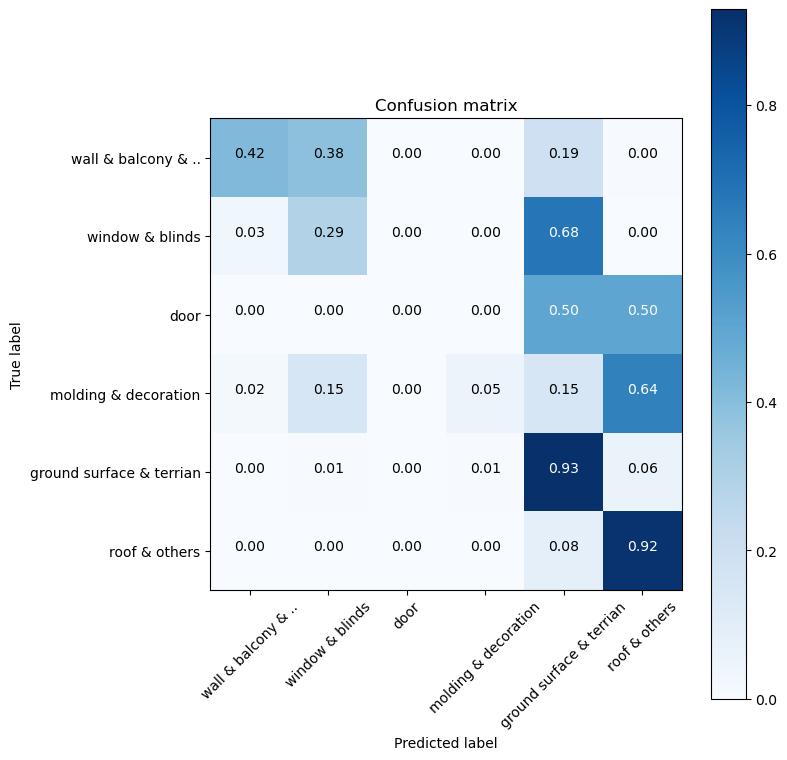

In [120]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(cla_test.keys()), normalize=True)

Confusion matrix, without normalization


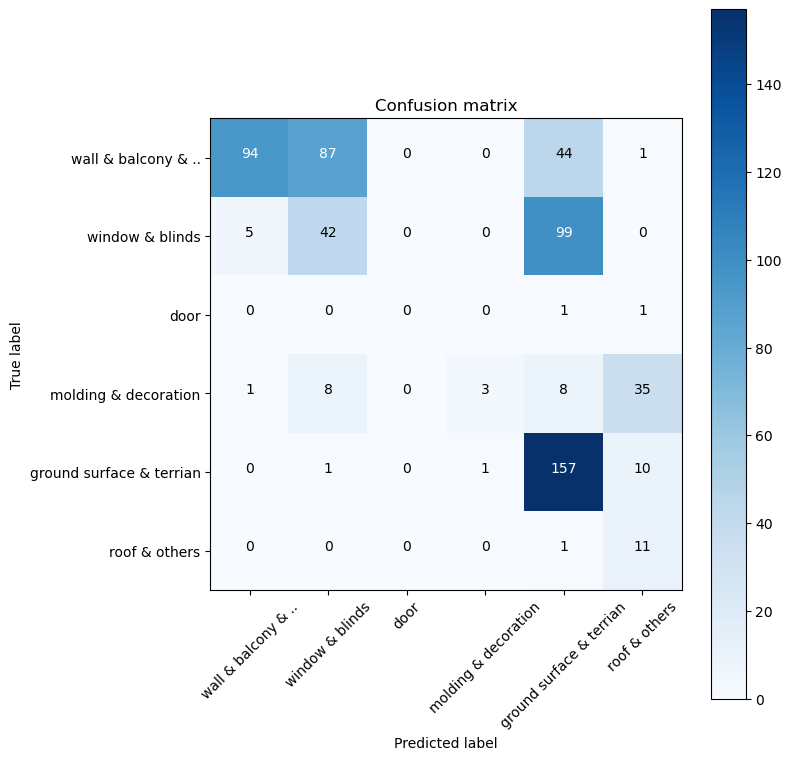

In [121]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(cla_test.keys()), normalize=False)